#### Date: 21-06-2022

#### Challenge: multiclass classification for <code>ChestMNIST</code> dataset (https://arxiv.org/abs/2110.14795)
#### Tutorial: https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [158]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist as medm
from medmnist import INFO, Evaluator
import pandas as pd

In [159]:
data_flag = 'chestmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 256
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medm, info['python_class'])

In [160]:
DataClass

medmnist.dataset.ChestMNIST

In [161]:
n_classes

14

In [169]:
info

{'python_class': 'ChestMNIST',
 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.',
 'url': 'https://zenodo.org/record/6496656/files/chestmnist.npz?download=1',
 'MD5': '02c8a6516a18b556561a56cbdd36c4a8',
 'task': 'multi-label, binary-class',
 'label': {'0': 'atelectasis',
  '1': 'cardiomegaly',
  '2': 'effusion',
  '3': 'infiltration',
  '4': 'mass',
  '5': 'nodule',
  '6': 'pneumonia',
  '7': 'pneumothorax',
  '8': 'consolidation',
  '9': 'edema',
  '10': 'emphysema',
  '11': 'fibrosis',
  '12': 'pleural',
  '13': 'hernia'},
 'n_channels': 1,
 'n_samples': {'train': 78468, 'val': 11219, 'test': 22433},
 'license': 'CC BY 4.0'}

In [170]:
task # we should choose 'multi-label'

'multi-label, binary-class'

In [171]:
# define a preprocessing func to normalize data
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

In [172]:
# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /home/jiawei/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jiawei/.medmnist/chestmnist.npz
Using downloaded and verified file: /home/jiawei/.medmnist/chestmnist.npz


/home/jiawei/anaconda3/envs/r_env/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


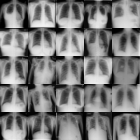

In [174]:
# visualization as per montage
train_dataset.montage(length=5)

#### Then, we define a baseline model for illustration using ResNet18 (28) NN arch, object function and optimizer that we use to classify.
#### Constructing ResNet18 from Scratch in Python https://www.kaggle.com/code/ivankunyankin/resnet18-from-scratch-using-pytorch/notebook

In [40]:
class Block(nn.Module):
    
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        return x

    
class ResNet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            Block(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            Block(out_channels, out_channels)
        )
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

resn18_model = ResNet18(n_channels, n_classes)

#### Perform traning and evaluation

In [48]:
# define the loss function and optimizer
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

# Try to use
#optimizer_adam = optim.Adam(resn18_model.parameters(), lr=lr, weight_decay=1e-4)
optimizer = optim.SGD(resn18_model.parameters(), lr=lr, momentum=0.9)

# train ChestMNIST Data for 3 epochs

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    resn18_model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = resn18_model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|█████████████████████████████████████████| 307/307 [37:40<00:00,  7.36s/it]


#### Save the model and predict

In [52]:
%%bash
mkdir -p manuel_git_repo/notebooks/resnet18_chestmnist_test

In [56]:
# save states of the trained model
torch.save(resn18_model.state_dict(), "manuel_git_repo/notebooks/resnet18_chestmnist_test/3epochs_model")

In [58]:
%%bash
wc -l manuel_git_repo/resnet18_chestmnist_test/3epochs_model

154534 manuel_git_repo/resnet18_chestmnist_test/3epochs_model


In [180]:
# predict the test dataset using the train model (3 epochs)
resn18_model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = resn18_model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            outputs = outputs.softmax(dim=-1)
        # "else" part could be ignored since we don't evaluate other types of datasets 
        else:
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)
print(y_true.size(), y_score.size())

torch.Size([22433, 14]) torch.Size([22433, 14])


#### How was AUC and ACC calculated in the source code of <code>MedMNIST</code>?: https://github.com/MedMNIST/MedMNIST/blob/d8422ac64028488133fd21ff54372729e12bbaba/medmnist/evaluator.py
#### Answer: There were only the arithmetic means of AUC/ACC at all labels

In [93]:
#y_true = y_true.numpy()
#y_score = y_score.detach().numpy()    
print(np.shape(y_true), np.shape(y_score))
evaluator = Evaluator(data_flag, 'test')
metrics = evaluator.evaluate(y_score)    
print('==> Evaluating ...')
print(metrics)

(22433, 14) (22433, 14)
==> Evaluating ...
Metrics(AUC=0.5947056293188621, ACC=0.9463481732906242)


In [ ]:
# train ChestMNIST Data for 1 epoch
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    resn18_model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = resn18_model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

In [144]:
# save the one-epoch model to an external file
torch.save(resn18_model.state_dict(), "manuel_git_repo/notebooks/resnet18_chestmnist_test/1epoch_model")

In [122]:
# evaluate the 1 epoch model using ACC and AUC as metrics
# predict the test dataset using the train model (1 epoch)
resn18_model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = resn18_model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            outputs = outputs.softmax(dim=-1)
        # "else" part could be ignored since we don't evaluate other types of datasets 
        else:
            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)
print(y_true.size(), y_score.size())    
print(np.shape(y_true), np.shape(y_score))
evaluator = Evaluator(data_flag, 'test')
metrics = evaluator.evaluate(y_score)    
print('==> Evaluating ...')
print(metrics)

torch.Size([22433, 14]) torch.Size([22433, 14])
torch.Size([22433, 14]) torch.Size([22433, 14])
==> Evaluating ...
Metrics(AUC=0.6075437745499812, ACC=0.9457049881870458)


In [130]:
from torch import sigmoid

In [ ]:
# evaluate the 1 epoch model using ACC and AUC as metrics, with softmax normalization
# predict the test dataset using the train model (1 epoch)
resn18_model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = resn18_model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            outputs = outputs.softmax(dim=-1)
        # "else" part could be ignored since we don't evaluate other types of datasets 
        else:
            targets = targets.squeeze().long()
            outputs = outputs.(dim=-1)
            targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)
print(y_true.size(), y_score.size())    
print(np.shape(y_true), np.shape(y_score))
evaluator = Evaluator(data_flag, 'test')
metrics = evaluator.evaluate(y_score)    
print('==> Evaluating ...')
print(metrics)

In [133]:
# evaluate the 1 epoch model using ACC and AUC as metrics, with sigmoid normalization
# predict the test dataset using the train model (3 epochs)
resn18_model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = resn18_model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            outputs = sigmoid(outputs)
        # "else" part could be ignored since we don't evaluate other types of datasets 
        else:
            targets = targets.squeeze().long()
            outputs = sigmoid(outputs)
            targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)
print(y_true.size(), y_score.size())    
print(np.shape(y_true), np.shape(y_score))
evaluator = Evaluator(data_flag, 'test')
metrics = evaluator.evaluate(y_score)    
print('==> Evaluating ...')
print(metrics)

torch.Size([22433, 14]) torch.Size([22433, 14])
torch.Size([22433, 14]) torch.Size([22433, 14])
==> Evaluating ...
Metrics(AUC=0.6676118807276293, ACC=0.9471378262890767)


In [134]:
# evaluate the 1 epoch model using ACC and AUC as metrics, without normalization
# predict the test dataset using the train model (1 epoch)
resn18_model.eval()
y_true = torch.tensor([])
y_score = torch.tensor([])
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = resn18_model(inputs)
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            #outputs = sigmoid(outputs)
        # "else" part could be ignored since we don't evaluate other types of datasets 
        else:
            targets = targets.squeeze().long()
            #outputs = sigmoid(outputs)
            targets = targets.float().resize_(len(targets), 1)
        y_true = torch.cat((y_true, targets), 0)
        y_score = torch.cat((y_score, outputs), 0)
print(y_true.size(), y_score.size())    
print(np.shape(y_true), np.shape(y_score))
evaluator = Evaluator(data_flag, 'test')
metrics = evaluator.evaluate(y_score)    
print('==> Evaluating ...')
print(metrics)

torch.Size([22433, 14]) torch.Size([22433, 14])
torch.Size([22433, 14]) torch.Size([22433, 14])
==> Evaluating ...
Metrics(AUC=0.6676118807276293, ACC=0.9474466825021811)


#### Conclusion: as regards to AUC values, no normalization = sigmoid normalization > softmax normalization

---------------------------------------------------------------------------------------------------------------

#### Write a function to evaluate the precision/recall of the 1-epoch/3-epochs model

In [140]:
from sklearn.metrics import roc_auc_score, \
precision_recall_fscore_support
from typing import Any, List, Callable

In [192]:
def get_test_score(model: nn.Module, test_loader: torch.utils.data.DataLoader, threshold=0.5): 
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            logits = model(inputs)
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            #outputs = outputs.softmax(dim=-1)
            predictions = (outputs > threshold).int()
            predictions = (logits > threshold).int()
            # Concatenate this batch to the complete results
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, predictions), 0)
        print(y_true.shape, y_score.shape)
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_score)
        return precision, recall, f1
        """
        # averaged auc value per label, unnecessary here
        auc = 0
        for i in range(y_score.shape[1]):
            try:
                label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
                precision, recall, f1, support = precision_recall_fscore_support(y_true[:, i])
                auc += label_auc
            except ValueError:
                # If all labels are of the same value, an ValueError is thrown
                # Equal to: auc += 0.0
                pass
        return auc / y_score.shape[1]
        """

#### Start the evaluation for precision and recall value for the 3-epoch ResNet18 model

In [145]:
# load the three-epoch model
resn18_model_3 = ResNet18(n_channels, n_classes)
resn18_model_3.load_state_dict(torch.load("manuel_git_repo/notebooks/resnet18_chestmnist_test/3epochs_model"))
# load the one-epoch model
resn18_model_1 = ResNet18(n_channels, n_classes)
resn18_model_1.load_state_dict(torch.load("manuel_git_repo/notebooks/resnet18_chestmnist_test/1epoch_model"))

<All keys matched successfully>

In [188]:
eval_3epochs = get_test_score(model=resn18_model_3, test_loader=test_loader)
eval_1epoch =  get_test_score(model=resn18_model_1, test_loader=test_loader)

torch.Size([22433, 14]) torch.Size([22433, 14])


/home/jiawei/anaconda3/envs/r_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


torch.Size([22433, 14]) torch.Size([22433, 14])


/home/jiawei/anaconda3/envs/r_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [189]:
for res, epc in zip((eval_3epochs, eval_3epochs), ('3 epochs', '1 epoch')):
    print(f"precision for a model trained for {epc} epochs: precision-{res[0]} recall-{res[1]} f1-{res[2]}")

precision for a model trained for 3 epochs epochs: precision-[0.2        0.         0.51666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] recall-[0.00041322 0.         0.02251271 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] f1-[0.00082474 0.         0.04314544 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
precision for a model trained for 1 epoch epochs: precision-[0.2        0.         0.51666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] recall-[0.00041322 0.         0.02251271 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] f1-[0.00082474 0.         0.04314544 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


#### Conclusion: the results appear to be extremely low in all the three metrics. Therefore, there was either problem in the training data or the input processing. When the threshold is 0.5, it behaves like that. 
#### Moreover, the 1-epoch model appears to be different. Let's try the 3-epochs model only at the moment.

#### Instead, I whould like to try a pre-trained ResNet18 model for testing

In [200]:
from torchvision import models

In [209]:
resnet18_trained = models.resnet18(pretrained=True)
resnet18_trained.fc # check the dimension of the original pretrained fully-connected layer

In [220]:
resnet18_trained.fc = nn.Linear(512, 14, bias=True)

#### Since the final fully-connected layer was modified, we would need to train on the final layer again (1 epoch for this time)

In [239]:
for name, param in resnet18_trained.named_parameters():
    print(name, param.size())

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

In [241]:
resnet18_trained.layer1.requires_grad=False
resnet18_trained.layer2.requires_grad=False
resnet18_trained.layer3.requires_grad=False
resnet18_trained.layer4.requires_grad=False

In [248]:
# train only the final fully connected layer using ChestMNIST Data for 1 epoch
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    resnet18_trained.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = resnet18_trained(inputs.repeat(1, 3, 1, 1))
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 307/307 [31:01<00:00,  6.06s/it]


In [225]:
def get_test_score(model: nn.Module, test_loader: torch.utils.data.DataLoader, threshold=0.5): 
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    with torch.no_grad():
        for inputs, targets in test_loader:
            # convert a one-channel input into a three-channel one
            inputs = inputs.repeat(1, 3, 1, 1)
            outputs = model(inputs)
            #print(outputs.shape)
            logits = model(inputs)
            targets = targets.to(torch.float32)
            # use softmax instead of standard normalization
            #outputs = outputs.softmax(dim=-1)
            predictions = (outputs > threshold).int()
            predictions = (logits > threshold).int()
            # Concatenate this batch to the complete results
            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, predictions), 0)
        print(y_true.shape, y_score.shape)
        precision, recall, f1, support = precision_recall_fscore_support(y_true, y_score)
        return precision, recall, f1
        """
        # averaged auc value per label, unnecessary here
        auc = 0
        for i in range(y_score.shape[1]):
            try:
                label_auc = roc_auc_score(y_true[:, i], y_score[:, i])
                precision, recall, f1, support = precision_recall_fscore_support(y_true[:, i])
                auc += label_auc
            except ValueError:
                # If all labels are of the same value, an ValueError is thrown
                # Equal to: auc += 0.0
                pass
        return auc / y_score.shape[1]
        """

In [226]:
eval_pretrained =  get_test_score(model=resnet18_trained, test_loader=test_loader)

torch.Size([22433, 14]) torch.Size([22433, 14])


/home/jiawei/anaconda3/envs/r_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [251]:
res = eval_pretrained
print(f"precision for a pretrained ResNet18 model at ImageNet: precision-{res[0]} recall-{res[1]} f1-{res[2]}")

precision for a pretrained ResNet18 model at ImageNet: precision-[0.11393229 0.02574257 0.12909344 0.1842714  0.04283802 0.06145251
 0.01114206 0.0706619  0.04842083 0.01591512 0.0297542  0.01794505
 0.03227176 0.00224115] recall-[0.1446281  0.06701031 0.37073348 0.06069071 0.0282436  0.1071161
 0.04958678 0.21763085 0.48380355 0.08716707 0.04518664 0.3121547
 0.10354223 0.23809524] f1-[0.12745812 0.03719599 0.19150333 0.0913085  0.03404255 0.0780994
 0.0181956  0.10668467 0.08803118 0.02691589 0.03588144 0.03393903
 0.04920686 0.0044405 ]


In [256]:
print(f"avg recall: {round(np.mean(res[1]), 4)}, avg precision: {round(np.mean(res[2]), 4)}")

avg recall: 0.1654, avg precision: 0.0659


-----------------------------------------------------------------------------------------------